In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score

In [2]:
file_path = '/content/drive/MyDrive/Churn_pred/customer_churn_large_dataset.xlsx'
df = pd.read_excel(file_path)

#### Since

In [3]:
df_encoded = df.drop(['CustomerID', 'Name'], axis=1)

labelencoder = LabelEncoder()
df_encoded['Gender'] = labelencoder.fit_transform(df_encoded['Gender'])
df_encoded['Location'] = labelencoder.fit_transform(df_encoded['Location'])

In [4]:
df_encoded['Bill_to_Usage_Ratio'] = df_encoded['Monthly_Bill'] / df_encoded['Total_Usage_GB']
df_encoded['Age_x_Subscription_Length'] = df_encoded['Age'] * df_encoded['Subscription_Length_Months']
df_encoded['Subscription_Length_Square'] = df_encoded['Subscription_Length_Months'] ** 2
df_encoded['Monthly_Bill_Square'] = df_encoded['Monthly_Bill'] ** 2

In [5]:
df_encoded['Age_x_Monthly_Bill'] = df_encoded['Age'] * df_encoded['Monthly_Bill']
df_encoded['Usage_per_Bill'] = df_encoded['Total_Usage_GB'] / df_encoded['Monthly_Bill']
bins = [0, 6, 12, 24]
labels = ['New', 'Mid-Term', 'Long-Term']
df_encoded['Customer_Tenure_Group'] = pd.cut(df_encoded['Subscription_Length_Months'], bins=bins, labels=labels, right=True)
df_encoded = pd.get_dummies(df_encoded, columns=['Customer_Tenure_Group'], drop_first=True)
high_bill_threshold = df_encoded['Monthly_Bill'].quantile(0.75)
df_encoded['High_Bill_Flag'] = (df_encoded['Monthly_Bill'] > high_bill_threshold).astype(int)
low_usage_threshold = df_encoded['Total_Usage_GB'].quantile(0.25)
df_encoded['Low_Usage_Flag'] = (df_encoded['Total_Usage_GB'] < low_usage_threshold).astype(int)

In [6]:
df_encoded

,Age,Gender,Location,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn,Bill_to_Usage_Ratio,Age_x_Subscription_Length,Subscription_Length_Square,Monthly_Bill_Square,Age_x_Monthly_Bill,Usage_per_Bill,Customer_Tenure_Group_Mid-Term,Customer_Tenure_Group_Long-Term,High_Bill_Flag,Low_Usage_Flag
0,63,1,2,17,73.36,236,0,0.310847,1071,289,5381.6896,4621.68,3.217012,0,1,0,0
1,62,0,4,1,48.76,172,0,0.283488,62,1,2377.5376,3023.12,3.527482,0,0,0,0
2,24,0,2,5,85.47,460,0,0.185804,120,25,7305.1209,2051.28,5.382005,0,0,1,0
3,36,0,3,3,97.94,297,1,0.329764,108,9,9592.2436,3525.84,3.032469,0,0,1,0
4,46,0,3,19,58.14,266,0,0.218571,874,361,3380.2596,2674.44,4.575163,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,33,1,1,23,55.13,226,1,0.243938,759,529,3039.3169,1819.29,4.099401,0,1,0,0
99996,62,0,4,19,61.65,351,0,0.175641,1178,361,3800.7225,3822.30,5.693431,0,1,0,0
99997,64,1,0,17,96.11,251,1,0.382908,1088,289,9237.1321,6151.04,2.611591,0,1,1,0
99998,51,0,4,20,49.25,434,1,0.113479,1020,400,2425.5625,2511.75,8.812183,0,1,0,0


#### Correlation Matrix

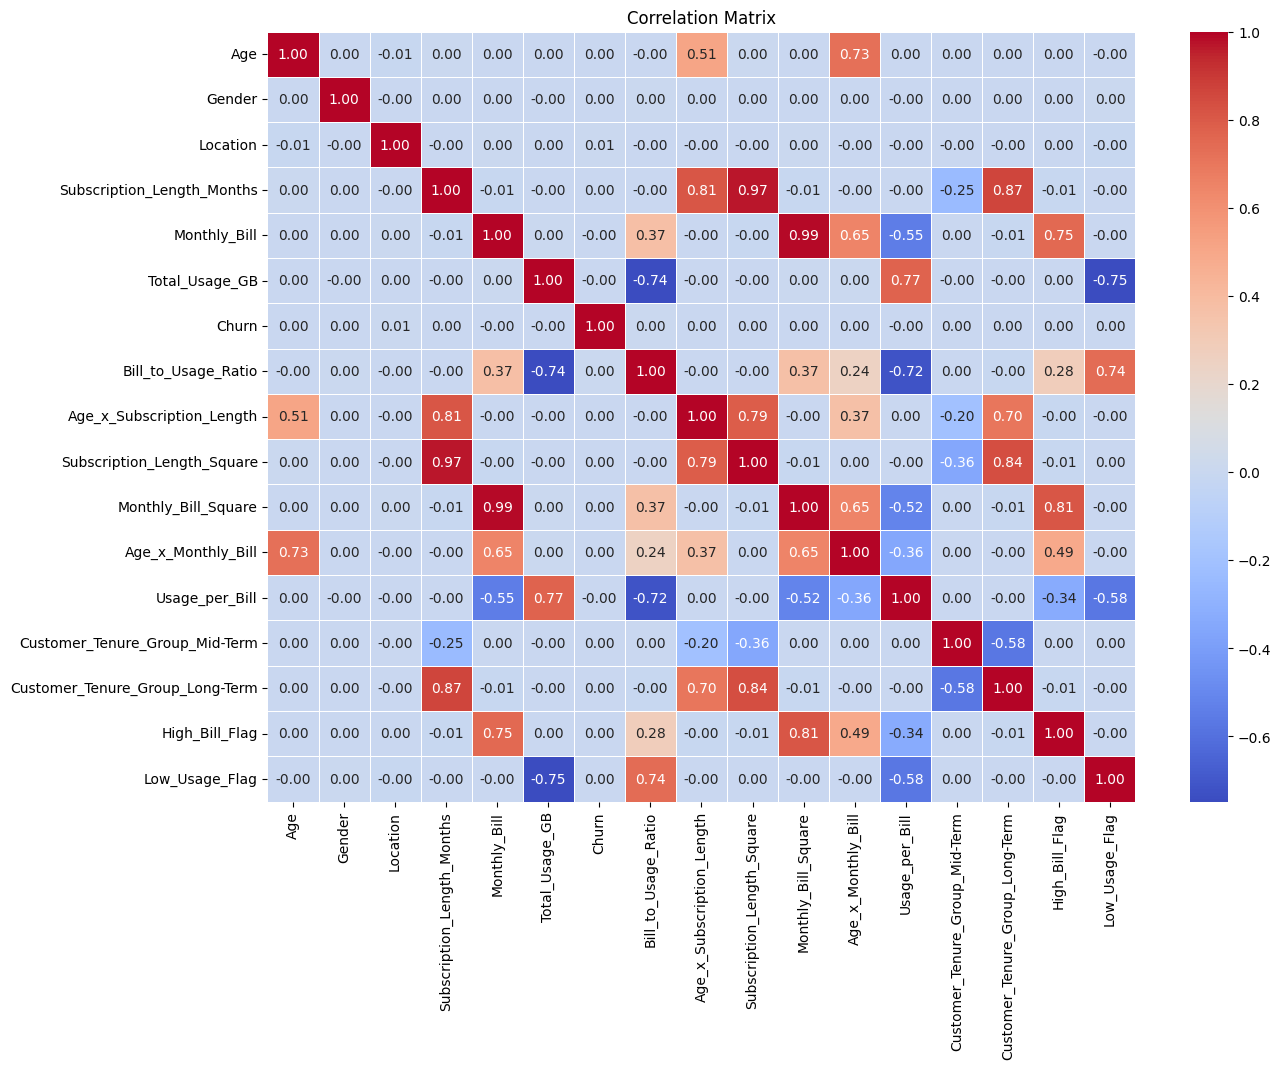

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df_encoded.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=.5, cbar=True)
plt.title("Correlation Matrix")
plt.show()

## Mutual information

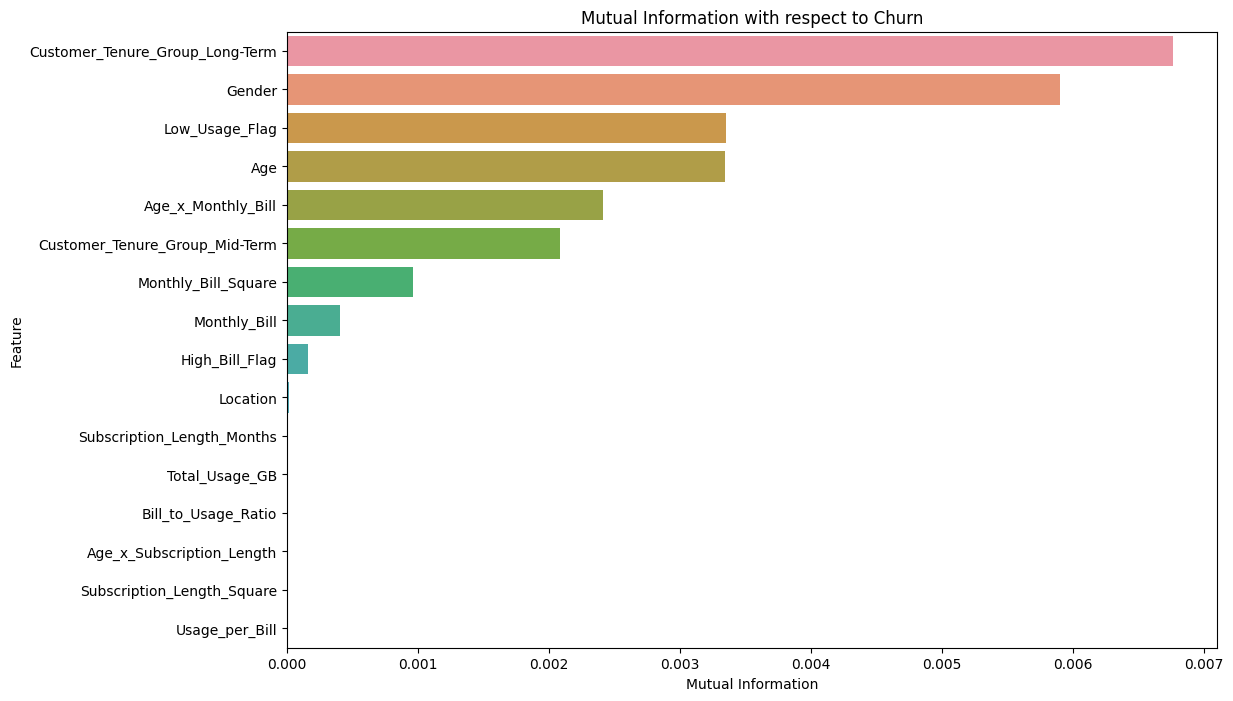

In [8]:
from sklearn.feature_selection import mutual_info_classif

X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

mutual_info = mutual_info_classif(X, y, random_state=42)

mi_df = pd.DataFrame({'Feature': X.columns, 'Mutual Information': mutual_info})

mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Mutual Information', y='Feature', data=mi_df)
plt.title('Mutual Information with respect to Churn')
plt.show()

#### Trying out models

In [9]:
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [10]:
# Logistic Regression
logistic_model = LogisticRegression(random_state=42, max_iter=500)
logistic_model.fit(X_train, y_train)
y_pred_logistic = logistic_model.predict(X_test)
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
f1_logistic = f1_score(y_test, y_pred_logistic)

In [11]:
# Random Forest
random_forest_model = RandomForestClassifier(random_state=42, n_jobs=-1)
random_forest_model.fit(X_train, y_train)
y_pred_rf = random_forest_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

In [12]:
# AdaBoost
ada_model = AdaBoostClassifier(random_state=42)
ada_model.fit(X_train, y_train)
y_pred_ada = ada_model.predict(X_test)
accuracy_ada = accuracy_score(y_test, y_pred_ada)
f1_ada = f1_score(y_test, y_pred_ada)

In [13]:
# XGBoost
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [14]:
# LightGBM
lgbm_model = LGBMClassifier(random_state=42)
lgbm_model.fit(X_train, y_train)
y_pred_lgbm = lgbm_model.predict(X_test)
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
f1_lgbm = f1_score(y_test, y_pred_lgbm)

[LightGBM] [Info] Number of positive: 34845, number of negative: 35155
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1899
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497786 -> initscore=-0.008857
[LightGBM] [Info] Start training from score -0.008857


In [15]:
# Display the results
print("Model Evaluation Metrics:")
print(f"Logistic Regression - Accuracy: {accuracy_logistic}, F1 Score: {f1_logistic}")
print(f"Random Forest - Accuracy: {accuracy_rf}, F1 Score: {f1_rf}")
print(f"AdaBoost - Accuracy: {accuracy_ada}, F1 Score: {f1_ada}")
print(f"XGBoost - Accuracy: {accuracy_xgb}, F1 Score: {f1_xgb}")
print(f"LightGBM - Accuracy: {accuracy_lgbm}, F1 Score: {f1_lgbm}")

Model Evaluation Metrics:
Logistic Regression - Accuracy: 0.49883333333333335, F1 Score: 0.3664405208377228
Random Forest - Accuracy: 0.49633333333333335, F1 Score: 0.47996971365638763
AdaBoost - Accuracy: 0.5016666666666667, F1 Score: 0.44780970672970377
XGBoost - Accuracy: 0.49643333333333334, F1 Score: 0.48385664013119684
LightGBM - Accuracy: 0.5015666666666667, F1 Score: 0.4547277832476388


#### Hyperparameter Tuning

In [16]:
# AdaBoost

from sklearn.model_selection import GridSearchCV
param_grid_ada = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1]
}

ada_model = AdaBoostClassifier(random_state=42)

grid_ada = GridSearchCV(ada_model, param_grid_ada, cv=3, scoring='accuracy')

grid_ada.fit(X_train, y_train)

best_params_ada = grid_ada.best_params_

In [18]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [19]:
best_ada_model = AdaBoostClassifier(**best_params_ada, random_state=42)
best_ada_model.fit(X_train, y_train)
y_pred_ada_best = best_ada_model.predict(X_test)

accuracy_ada_best = accuracy_score(y_test, y_pred_ada_best)
f1_ada_best = f1_score(y_test, y_pred_ada_best)
precision_ada_best = precision_score(y_test, y_pred_ada_best)
recall_ada_best = recall_score(y_test, y_pred_ada_best)

print("AdaBoost - Accuracy:", accuracy_ada_best, "F1:", f1_ada_best, "Precision:", precision_ada_best, "Recall:", recall_ada_best)

AdaBoost - Accuracy: 0.5004333333333333 F1: 0.41518710734771924 Precision: 0.4975217431964837 Recall: 0.356234096692112


In [20]:
# XGBoost

param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

grid_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=3, scoring='accuracy')

grid_xgb.fit(X_train, y_train)

best_params_xgb = grid_xgb.best_params_

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarnin

In [21]:
best_xgb_model = XGBClassifier(**best_params_xgb, random_state=42, use_label_encoder=False, eval_metric='logloss')
best_xgb_model.fit(X_train, y_train)
y_pred_xgb_best = best_xgb_model.predict(X_test)

accuracy_xgb_best = accuracy_score(y_test, y_pred_xgb_best)
f1_xgb_best = f1_score(y_test, y_pred_xgb_best)
precision_xgb_best = precision_score(y_test, y_pred_xgb_best)
recall_xgb_best = recall_score(y_test, y_pred_xgb_best)

print("XGBoost - Accuracy:", accuracy_xgb_best, "F1:", f1_xgb_best, "Precision:", precision_xgb_best, "Recall:", recall_xgb_best)

XGBoost - Accuracy: 0.5009666666666667 F1: 0.38721296713192255 Precision: 0.49805201642623986 Recall: 0.3167269318334003


In [22]:
## LGBM

param_grid_lgbm = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

lgbm_model = LGBMClassifier(random_state=42)

grid_lgbm = GridSearchCV(lgbm_model, param_grid_lgbm, cv=3, scoring='accuracy')

grid_lgbm.fit(X_train, y_train)

best_params_lgbm = grid_lgbm.best_params_

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly 

In [23]:
best_lgbm_model = LGBMClassifier(**best_params_lgbm, random_state=42)
best_lgbm_model.fit(X_train, y_train)
y_pred_lgbm_best = best_lgbm_model.predict(X_test)

accuracy_lgbm_best = accuracy_score(y_test, y_pred_lgbm_best)
f1_lgbm_best = f1_score(y_test, y_pred_lgbm_best)
precision_lgbm_best = precision_score(y_test, y_pred_lgbm_best)
recall_lgbm_best = recall_score(y_test, y_pred_lgbm_best)

print("LightGBM - Accuracy:", accuracy_lgbm_best, "F1:", f1_lgbm_best, "Precision:", precision_lgbm_best, "Recall:", recall_lgbm_best)

[LightGBM] [Info] Number of positive: 34845, number of negative: 35155
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1899
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497786 -> initscore=-0.008857
[LightGBM] [Info] Start training from score -0.008857
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


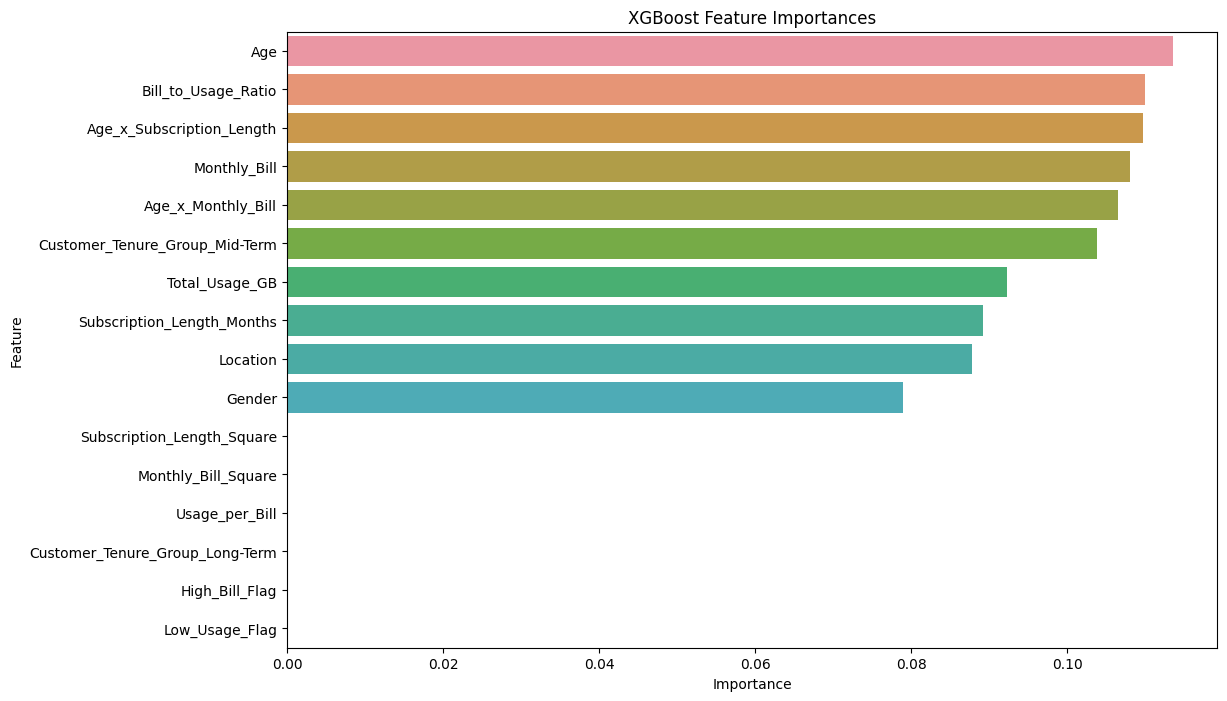

In [25]:
import matplotlib.pyplot as plt

best_xgb_model = XGBClassifier(**best_params_xgb, random_state=42, use_label_encoder=False, eval_metric='logloss')
best_xgb_model.fit(X_train, y_train)

feature_importances_xgb = best_xgb_model.feature_importances_

features_df_xgb = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances_xgb
})

features_df_xgb = features_df_xgb.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=features_df_xgb)
plt.title('XGBoost Feature Importances')
plt.show()

In [26]:
X_train.columns

Index(['Age', 'Gender', 'Location', 'Subscription_Length_Months',
       'Monthly_Bill', 'Total_Usage_GB', 'Bill_to_Usage_Ratio',
       'Age_x_Subscription_Length', 'Subscription_Length_Square',
       'Monthly_Bill_Square', 'Age_x_Monthly_Bill', 'Usage_per_Bill',
       'Customer_Tenure_Group_Mid-Term', 'Customer_Tenure_Group_Long-Term',
       'High_Bill_Flag', 'Low_Usage_Flag'],
      dtype='object')

In [27]:
drop_cols = ['Subscription_Length_Square', 'Monthly_Bill_Square', 'Usage_per_Bill', 'Customer_Tenure_Group_Long-Term','High_Bill_Flag', 'Low_Usage_Flag']

X_modified = X.drop(drop_cols, axis=1)

X_train_mod, X_test_mod, y_train, y_test = train_test_split(X_modified, y, test_size=0.3, random_state=42, stratify=y)

In [28]:
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

xgb_model_mod = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

grid_xgb_mod = GridSearchCV(xgb_model_mod, param_grid_xgb, cv=3, scoring='accuracy', n_jobs=-1)

grid_xgb_mod.fit(X_train_mod, y_train)

best_params_xgb_mod = grid_xgb_mod.best_params_
best_params_xgb_mod

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


{'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 200}

In [31]:
from sklearn.ensemble import StackingClassifier

# Initialize base-level models with best hyperparameters
best_ada_model = AdaBoostClassifier(**best_params_ada, random_state=42)
best_xgb_model = XGBClassifier(**best_params_xgb, random_state=42, use_label_encoder=False, eval_metric='logloss')
best_lgbm_model = LGBMClassifier(**best_params_lgbm, random_state=42)

# Initialize meta-model (Logistic Regression in this case)
meta_model = LogisticRegression()

# Define the ensemble model
ensemble_model = StackingClassifier(
    estimators=[
        ('AdaBoost', best_ada_model),
        ('XGBoost', best_xgb_model),
        ('LightGBM', best_lgbm_model)
    ],
    final_estimator=meta_model
)

# Train the ensemble model on the training data
ensemble_model.fit(X_train_mod, y_train)

# Make predictions on the test data
y_pred_ensemble = ensemble_model.predict(X_test_mod)

# Evaluation metrics
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
f1_ensemble = f1_score(y_test, y_pred_ensemble)
precision_ensemble = precision_score(y_test, y_pred_ensemble)
recall_ensemble = recall_score(y_test, y_pred_ensemble)

print("Ensemble Model - Accuracy:", accuracy_ensemble, "F1:", f1_ensemble, "Precision:", precision_ensemble, "Recall:", recall_ensemble)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[LightGBM] [Info] Number of positive: 34845, number of negative: 35155
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1358
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497786 -> initscore=-0.008857
[LightGBM] [Info] Start training from score -0.008857
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[LightGBM] [Info] Number of positive: 27876, number of negative: 28124
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001822 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1357
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497786 -> initscore=-0.008857
[LightGBM] [Info] Start training from score -0.008857
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 27876, number of negative: 28124
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1358
[LightGBM] [Info] N

In [24]:
import pickle

save_directory = "/content/drive/MyDrive/Churn_pred"

with open(f"{save_directory}/AdaBoost_best_model.pkl", 'wb') as f:
    pickle.dump(best_ada_model, f)

with open(f"{save_directory}/XGBoost_best_model.pkl", 'wb') as f:
    pickle.dump(best_xgb_model, f)

with open(f"{save_directory}/LightGBM_best_model.pkl", 'wb') as f:
    pickle.dump(best_lgbm_model, f)